In [ ]:
!pip install scikit-image

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import TensorflowUtils as utils
#import read_LaMemDataset as lamem
import read_FlowersDataset as flowers
import datetime
import BatchDatsetReader as dataset
from six.moves import xrange
import os
import matplotlib.pyplot as plt
from scipy import misc
from scipy.misc import imread
from skimage import color
from scipy.misc import toimage

In [ ]:
flags = tf.app.flags
FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')
tf.flags.DEFINE_integer("batch_size", "10", "batch size for training")
tf.flags.DEFINE_string("logs_dir", "/data/logs", "path to logs directory")
tf.flags.DEFINE_string("data_dir", "/data/", "path to dataset")
tf.flags.DEFINE_float("learning_rate", "1e-4", "Learning rate for Adam Optimizer")
tf.flags.DEFINE_float("beta1", "0.9", "Beta 1 value to use in Adam Optimizer")
tf.flags.DEFINE_string("model_dir", "/data/imagenet-vgg-verydeep-19.mat", "Path to vgg model mat")
tf.flags.DEFINE_bool('debug', "False", "Debug mode: True/ False")
tf.flags.DEFINE_string('mode', "train", "Mode train/ test")
FLAGS = flags.FLAGS

In [15]:
MODEL_URL = 'http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat'
IMAGE_SIZE = 128
MAX_ITERATION = 6000
restore_model = False

# FLAGS.debug

In [3]:
def vgg_net(weights, image): # load the pre-trained VGG19 , https://arxiv.org/pdf/1409.1556.pdf
    layers = (
        # 'conv1_1', 'relu1_1',
        # skip conv1_1 of VGG
        'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    net = {}
    current = image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i + 2][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = utils.get_variable(np.transpose(kernels, (1, 0, 2, 3)), name=name + "_w")
            bias = utils.get_variable(bias.reshape(-1), name=name + "_b")
            current = utils.conv2d_basic(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current, name=name)
            if FLAGS.debug:
                utils.add_activation_summary(current)
        elif kind == 'pool':
            current = utils.avg_pool_2x2(current)
        net[name] = current
    return net


def HyperColumns(images, train_phase):
    print("setting up vgg initialized conv layers ...")
    model_data = utils.get_model_data(FLAGS.model_dir, MODEL_URL)

    weights = np.squeeze(model_data['layers'])

    with tf.variable_scope("HyperColumns") as scope:
        # VGG takes in 3channel (RGB) images. 
        # In order to input 1-channel (gray) image, 
        # define a new filter that takes in gray color image and map it into 64 channels so as to fit VGG conv1_2
        W0 = utils.weight_variable([3, 3, 1, 64], name="W0")
        b0 = utils.bias_variable([64], name="b0")
        conv0 = utils.conv2d_basic(images, W0, b0)
        hrelu0 = tf.nn.relu(conv0, name="relu")
        image_net = vgg_net(weights, hrelu0)

        # HyperColumns
        # https://arxiv.org/abs/1411.5752
        relu1_2  = image_net["relu1_2"]
        layer_relu1_2 = tf.image.resize_bilinear(relu1_2, (IMAGE_SIZE, IMAGE_SIZE)) 

        relu2_1  = image_net["relu2_1"]
        layer_relu2_1 = tf.image.resize_bilinear(relu2_1, (IMAGE_SIZE, IMAGE_SIZE)) 
        
        relu2_2  = image_net["relu2_2"]
        layer_relu2_2 = tf.image.resize_bilinear(relu2_2, (IMAGE_SIZE, IMAGE_SIZE)) 

        relu3_1  = image_net["relu3_1"]
        layer_relu3_1 = tf.image.resize_bilinear(relu3_1, (IMAGE_SIZE, IMAGE_SIZE))         
        relu3_2  = image_net["relu3_2"]
        layer_relu3_2 = tf.image.resize_bilinear(relu3_2, (IMAGE_SIZE, IMAGE_SIZE)) 
        relu3_3  = image_net["relu3_3"]
        layer_relu3_3 = tf.image.resize_bilinear(relu3_3, (IMAGE_SIZE, IMAGE_SIZE)) 
        
        relu3_4  = image_net["relu3_4"]
        layer_relu3_4 = tf.image.resize_bilinear(relu3_4, (IMAGE_SIZE, IMAGE_SIZE))         
        relu4_1  = image_net["relu4_1"]
        layer_relu4_1 = tf.image.resize_bilinear(relu4_1, (IMAGE_SIZE, IMAGE_SIZE)) 
        relu4_2  = image_net["relu4_2"]
        layer_relu4_2 = tf.image.resize_bilinear(relu4_2, (IMAGE_SIZE, IMAGE_SIZE)) 
        relu4_3  = image_net["relu4_3"]
        layer_relu4_3 = tf.image.resize_bilinear(relu4_3, (IMAGE_SIZE, IMAGE_SIZE)) 
        relu4_4  = image_net["relu4_4"]
        layer_relu4_4 = tf.image.resize_bilinear(relu4_4, (IMAGE_SIZE, IMAGE_SIZE)) 
        
        relu5_1  = image_net["relu5_1"]
        layer_relu5_1 = tf.image.resize_bilinear(relu5_1, (IMAGE_SIZE, IMAGE_SIZE))         
        relu5_2  = image_net["relu5_2"]
        layer_relu5_2 = tf.image.resize_bilinear(relu5_2, (IMAGE_SIZE, IMAGE_SIZE))         
        relu5_3  = image_net["relu5_3"]
        layer_relu5_3 = tf.image.resize_bilinear(relu5_3, (IMAGE_SIZE, IMAGE_SIZE))         
        relu5_4  = image_net["relu5_4"]
        layer_relu5_4 = tf.image.resize_bilinear(relu5_4, (IMAGE_SIZE, IMAGE_SIZE))        
        
        HyperColumns = tf.concat([layer_relu1_2, \
                                     layer_relu2_1, layer_relu2_2, \
                                     layer_relu3_1, layer_relu3_2, layer_relu3_3, layer_relu3_4, \
                                     layer_relu4_1, layer_relu4_2, layer_relu4_3, layer_relu4_4, \
                                     layer_relu5_1, layer_relu5_2, layer_relu5_3, layer_relu5_4  \
                                    ] ,3)
        wc1 = utils.weight_variable([1, 1, 5440, 2], name="wc1")
        wc1_biase = utils.bias_variable([2], name="wc1_biase")
        pred_AB_conv = tf.nn.conv2d(HyperColumns, wc1, [1, 1, 1, 1], padding='SAME')
        pred_AB = tf.nn.bias_add(pred_AB_conv, wc1_biase)        
    return tf.concat(values=[images, pred_AB], axis=3,  name="pred_image")

def train(loss, var_list):
    optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate, beta1=FLAGS.beta1)
    grads = optimizer.compute_gradients(loss, var_list=var_list)
    for grad, var in grads:
        utils.add_gradient_summary(grad, var)
    return optimizer.apply_gradients(grads)




In [4]:
print("Setting up network...")
train_phase = tf.placeholder(tf.bool, name="train_phase")
images = tf.placeholder(tf.float32, shape=[None, None, None, 1], name='L_images')
lab_images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name="LAB_images")
pred_image = HyperColumns(images, train_phase)

gen_loss_mse = tf.reduce_mean(2 * tf.nn.l2_loss(pred_image - lab_images)) / (IMAGE_SIZE * IMAGE_SIZE * 100 * 100)
tf.summary.scalar("HyperColumns_loss_MSE", gen_loss_mse)

train_variables = tf.trainable_variables()
for v in train_variables:
    utils.add_to_regularization_and_summary(var=v)

train_op = train(gen_loss_mse, train_variables)





Setting up network...
setting up vgg initialized conv layers ...


In [5]:
print("Reading image dataset...")
train_images, testing_images, validation_images = flowers.read_dataset(FLAGS.data_dir)
image_options = {"resize": True, "resize_size": IMAGE_SIZE, "color": "LAB"}
batch_reader_train = dataset.BatchDatset(train_images, image_options)
batch_reader_validate = dataset.BatchDatset(validation_images, image_options)
batch_reader_testing = dataset.BatchDatset(testing_images, image_options)

Reading image dataset...
##########gadgsdgdsgdsfe44765534
('os.path.exists(pickle_filepath) =', True)
Found pickle file!
Training: 2570, Validation: 550, Test: 550
Initializing Batch Dataset Reader...
{'color': 'LAB', 'resize': True, 'resize_size': 128}
(2570, 128, 128, 3)
Initializing Batch Dataset Reader...
{'color': 'LAB', 'resize': True, 'resize_size': 128}
(550, 128, 128, 3)
Initializing Batch Dataset Reader...
{'color': 'LAB', 'resize': True, 'resize_size': 128}
(550, 128, 128, 3)


In [6]:
print("Setting up session")
sess = tf.Session()
summary_op = tf.summary.merge_all()
saver = tf.train.Saver()
train_writer = tf.summary.FileWriter(FLAGS.logs_dir + '/train', sess.graph)
validate_writer = tf.summary.FileWriter(FLAGS.logs_dir + '/validate')

sess.run(tf.global_variables_initializer())


Setting up session


In [7]:
if restore_model == True:
    ckpt = tf.train.get_checkpoint_state(FLAGS.logs_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        print("Model restored...")

In [19]:
FLAGS.mode = 'test'

In [20]:
check_variables_trainable = False
if check_variables_trainable == True :
    print('printing out the trainable variables...')
    variables_names = [v.name for v in tf.trainable_variables()]
    values = sess.run(variables_names)
    for k, v in zip(variables_names, values):
        print ("Variable: ", k)
        print ("Shape: ", v.shape)

mse_train_list = []
if FLAGS.mode == 'train':
        for itr in xrange(MAX_ITERATION):
            l_image, color_images = batch_reader_train.next_batch(FLAGS.batch_size)
            feed_dict = {images: l_image, lab_images: color_images, train_phase: True}

            if itr % 10 == 0:
                mse, summary_str = sess.run([gen_loss_mse, summary_op], feed_dict=feed_dict)
                mse_train_list.append(mse)
                train_writer.add_summary(summary_str, itr)
                print("Step: %d, MSE: %g" % (itr, mse))

            if itr % 100 == 0:
                saver.save(sess, FLAGS.logs_dir + "model.ckpt", itr)
                pred = sess.run(pred_image, feed_dict=feed_dict)
                idx = np.random.randint(0, FLAGS.batch_size)
                save_dir = os.path.join(FLAGS.logs_dir, "image_checkpoints")
                utils.save_image(color_images[idx], save_dir, "gt" + str(itr // 100))
                utils.save_image(pred[idx].astype(np.float64), save_dir, "pred" + str(itr // 100))
                print("%s --> Model saved" % datetime.datetime.now())

            sess.run(train_op, feed_dict=feed_dict)

            if itr % 10000 == 0:
                FLAGS.learning_rate /= 2
elif FLAGS.mode == "test":
    count = 10
    l_image, color_images = batch_reader_testing.get_N_images(count)
    feed_dict = {images: l_image, lab_images: color_images, train_phase: False}
    save_dir = os.path.join(FLAGS.logs_dir, "image_pred")
    pred = sess.run(pred_image, feed_dict=feed_dict)
    for itr in range(count):
        utils.save_image(color_images[itr], save_dir, "gt" + str(itr))
        utils.save_image(pred[itr].astype(np.float64), save_dir, "pred" + str(itr))
    print("--- Images saved on test run ---")
    

--- Images saved on test run ---


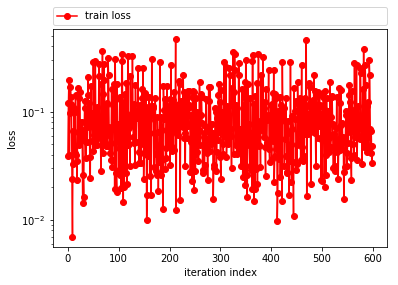

In [18]:
plot_train_loss = True
if plot_train_loss == True:
    plt.semilogy(mse_train_list[0:MAX_ITERATION], '-ro', label="train loss") # train loss
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.xlabel('iteration index')
    plt.ylabel('loss')
    plt.show()